In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import seaborn as sns

import sbibm
from sbibm.utils.io import get_tensor_from_csv

import sbi.analysis as analysis

from notebook import nre_gamma_default, prepare_df_for_plot, get_metrics, wide_to_long

In [3]:
df_prior = get_metrics(
    [
        "metrics-prior.csv",
    ],
    "prior",
)
df_joint = get_metrics(
    [
        "metrics-joint.csv",
    ],
    "joint",
)
df_bench = get_metrics(
    [
        "metrics-bench.csv",
    ],
    "bench",
)

df = pd.concat([df_joint, df_prior, df_bench], ignore_index=True)
df["gamma"] = df["gamma"].fillna(nre_gamma_default)

print(len(df))
print(df.columns)
print(df["algorithm"].unique())
print(df["task"].unique())
print(df["num_contrastive_parameters"].unique())
df.head()

1693
Index(['task', 'seed', 'algorithm', 'K', 'num_atoms',
       'num_contrastive_parameters', 'gamma', 'extra_theta_factor',
       'hidden_features', 'num_blocks', 'AVG_LOG_RATIO', 'RT', 'C2ST_Z-01',
       'MMD-01', 'MEDDIST-01', 'NLTP-01', 'C2ST_Z-02', 'MMD-02', 'MEDDIST-02',
       'NLTP-02', 'C2ST_Z-03', 'MMD-03', 'MEDDIST-03', 'NLTP-03', 'C2ST_Z-04',
       'MMD-04', 'MEDDIST-04', 'NLTP-04', 'C2ST_Z-05', 'MMD-05', 'MEDDIST-05',
       'NLTP-05', 'C2ST_Z-06', 'MMD-06', 'MEDDIST-06', 'NLTP-06', 'C2ST_Z-07',
       'MMD-07', 'MEDDIST-07', 'NLTP-07', 'C2ST_Z-08', 'MMD-08', 'MEDDIST-08',
       'NLTP-08', 'C2ST_Z-09', 'MMD-09', 'MEDDIST-09', 'NLTP-09', 'C2ST_Z-10',
       'MMD-10', 'MEDDIST-10', 'NLTP-10', 'NLTP', 'num_simulations_simulator',
       'path', 'folder', 'reuse', 'expr'],
      dtype='object')
['NRE-B' 'CNRE']
['slcp' 'two_moons' 'gaussian_mixture']
[200 100 150  10  25  75   2  50]


,task,seed,algorithm,K,num_atoms,num_contrastive_parameters,gamma,extra_theta_factor,hidden_features,num_blocks,...,C2ST_Z-10,MMD-10,MEDDIST-10,NLTP-10,NLTP,num_simulations_simulator,path,folder,reuse,expr
0,slcp,980488309,NRE-B,200,200,200,inf,False,50,2,...,0.82350,0.042112,2.018930,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/15,15,NaN,joint
1,two_moons,2456924169,NRE-B,100,100,100,inf,False,50,2,...,0.58885,0.002229,0.093457,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/5,5,NaN,joint
2,gaussian_mixture,4264851724,NRE-B,150,150,150,inf,False,50,2,...,0.69175,0.010666,0.745870,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/22,22,NaN,joint
3,slcp,2733803972,NRE-B,10,10,10,inf,False,50,2,...,0.87740,0.125824,2.029766,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/9,9,NaN,joint
4,slcp,3120623302,NRE-B,25,25,25,inf,False,50,2,...,0.87680,0.126860,1.861489,NaN,NaN,20504576.0,/home/ben/sci/cnre/infinite/joint/20-18-33/10,10,NaN,joint


In [4]:
df_wide, grp = wide_to_long(df)

In [5]:
df_preped = df_wide.reset_index()
df_preped["gamma"] = df_preped["gamma"].replace([nre_gamma_default], 1.0)

df_preped_copy = df_preped.copy()
df_preped_copy["task"] = "average"
df_preped = pd.concat([df_preped, df_preped_copy], ignore_index=True)

df_preped["C2ST"] = df_preped["C2ST_Z"]
df_preped["Contrastive parameter count"] = df_preped["num_contrastive_parameters"]
df_preped["algorithm"] = df_preped["algorithm"].map(lambda x: "NRE-C" if x == "CNRE" else x)
df_preped[r"Algorithm"] = df_preped.loc[:, "algorithm"]
df_preped[r"$\gamma$ (gamma)"] = df_preped.loc[:, "gamma"]

## joint

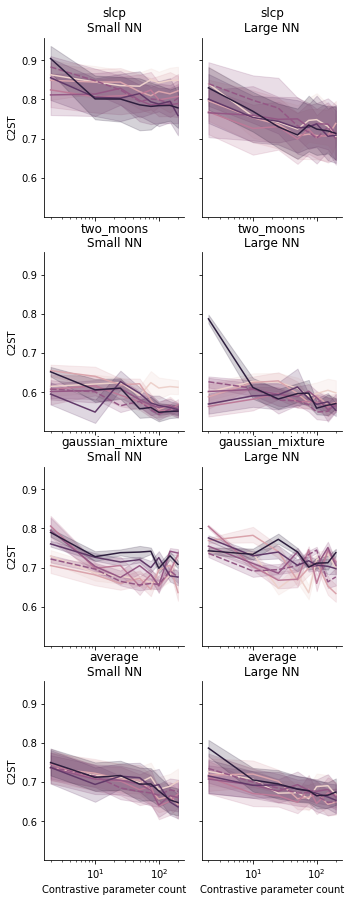

In [6]:
fg = sns.relplot(
    # data=prepare_df_for_plot(df_wide, "joint"),
    data=df_preped[df_preped["expr"] == "joint"],
    x="Contrastive parameter count",
    y="C2ST",
    hue="$\gamma$ (gamma)",
    style="Algorithm",
    style_order=["NRE-C", "NRE-B"],
    row="task",
    row_order=['slcp', 'two_moons', 'gaussian_mixture', 'average'],
    col="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
    height=2.5,
    legend=False,
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 
    
for ax in fg.axes[:, 0]:
    ax.set_ylabel("C2ST")
    
for key, ax in fg.axes_dict.items():
    title_parts = ax.get_title().split("|")
    
    title_parts[0] = title_parts[0].split("=")[-1].strip()
    
    if "2" in title_parts[-1]:
        title_parts[1] = "Small NN"
    elif "3" in title_parts[-1]:
        title_parts[1] = "Large NN"
    else:
        raise ValueError()
    
    ax.set_title(f"{title_parts[0]}\n{title_parts[-1]}")

fg.fig.subplots_adjust(top=1.2)
plt.savefig("rel-joint.pdf", dpi=300, bbox_inches="tight")

## prior

In [7]:
df_preped["task"].unique()

array(['slcp', 'two_moons', 'gaussian_mixture', 'average'], dtype=object)

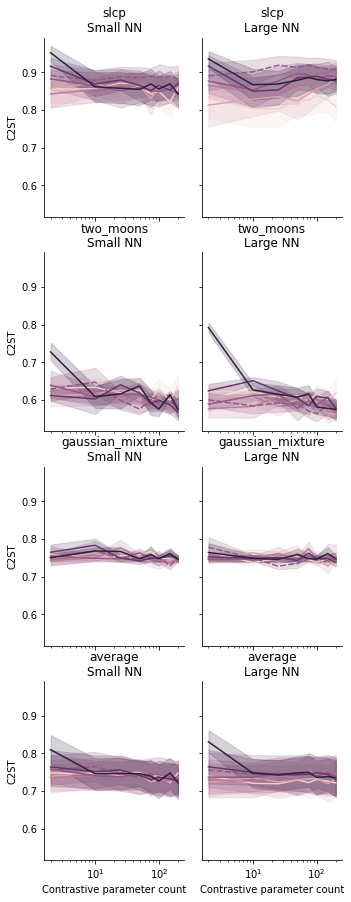

In [8]:
fg = sns.relplot(
    # data=prepare_df_for_plot(df_wide, "prior"),
    data=df_preped[df_preped["expr"] == "prior"],
    x="Contrastive parameter count",
    y="C2ST",
    hue="$\gamma$ (gamma)",
    style="Algorithm",
    style_order=["NRE-C", "NRE-B"],
    row="task",
    row_order=['slcp', 'two_moons', 'gaussian_mixture', 'average'],
    col="num_blocks",
    kind="line",
    height=2.5,
    hue_norm=LogNorm(),
    legend=False,
)
for ax in fg.axes.flatten():
    ax.set(xscale='log')

for ax in fg.axes[:, 0]:
    ax.set_ylabel("C2ST")
    
for key, ax in fg.axes_dict.items():
    title_parts = ax.get_title().split("|")
    
    title_parts[0] = title_parts[0].split("=")[-1].strip()
    
    if "2" in title_parts[-1]:
        title_parts[1] = "Small NN"
    elif "3" in title_parts[-1]:
        title_parts[1] = "Large NN"
    else:
        raise ValueError()
    
    ax.set_title(f"{title_parts[0]}\n{title_parts[-1]}")

fg.fig.subplots_adjust(top=1.2)
plt.savefig("rel-prior.pdf", dpi=300, bbox_inches="tight")

## bench

In [9]:
prepare_df_for_plot(df_wide, "bench")[prepare_df_for_plot(df_wide, "bench")["algorithm"] == "NRE-B"]["num_blocks"].unique()

array([2, 3])

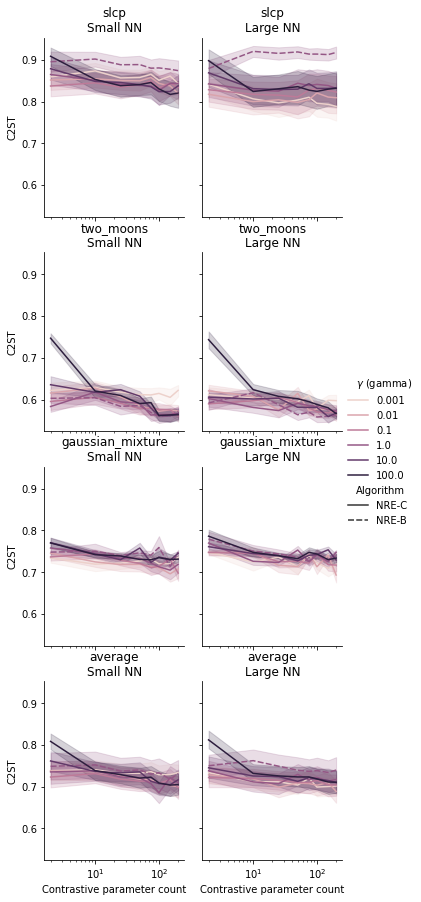

In [10]:
fg = sns.relplot(
    # data=prepare_df_for_plot(df_wide, "bench"),
    data=df_preped[df_preped["expr"] == "bench"],
    x="Contrastive parameter count",
    y="C2ST",
    hue="$\gamma$ (gamma)",
    style="Algorithm",
    style_order=["NRE-C", "NRE-B"],
    row="task",
    col="num_blocks",
    kind="line",
    height=2.5,
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log')

for ax in fg.axes[:, 0]:
    ax.set_ylabel("C2ST")
    
for key, ax in fg.axes_dict.items():
    title_parts = ax.get_title().split("|")
    
    title_parts[0] = title_parts[0].split("=")[-1].strip()
    
    if "2" in title_parts[-1]:
        title_parts[1] = "Small NN"
    elif "3" in title_parts[-1]:
        title_parts[1] = "Large NN"
    else:
        raise ValueError()
    
    ax.set_title(f"{title_parts[0]}\n{title_parts[-1]}")

fg.fig.subplots_adjust(top=1.2)
plt.savefig("rel-bench.pdf", dpi=300, bbox_inches="tight")

## average

In [11]:
prepare_df_for_plot(df_wide)[prepare_df_for_plot(df_wide)["task"] == "average"]
# prepare_df_for_plot(df_wide, "bench")[prepare_df_for_plot(df_wide, "bench")["algorithm"] == "NRE-B"]["num_blocks"].unique()

,task,algorithm,num_contrastive_parameters,gamma,num_blocks,hidden_features,seed,num_observation,MEDDIST-08,MMD-08,...,NLTP-07,MMD-03,MEDDIST-05,K,num_simulations_simulator,NLTP-04,NLTP-02,path,C2ST_Z,index
16930,average,NRE-B,200,1.00,2,50,980488309,1,24.299133,0.033668,...,NaN,0.019592,24.358020,200,20504576.0,NaN,NaN,/home/ben/sci/cnre/infinite/joint/20-18-33/15,0.80295,0.0
16931,average,NRE-B,200,1.00,2,50,980488309,2,24.299133,0.033668,...,NaN,0.019592,24.358020,200,20504576.0,NaN,NaN,/home/ben/sci/cnre/infinite/joint/20-18-33/15,0.81210,1.0
16932,average,NRE-B,200,1.00,2,50,980488309,3,24.299133,0.033668,...,NaN,0.019592,24.358020,200,20504576.0,NaN,NaN,/home/ben/sci/cnre/infinite/joint/20-18-33/15,0.71220,2.0
16933,average,NRE-B,200,1.00,2,50,980488309,4,24.299133,0.033668,...,NaN,0.019592,24.358020,200,20504576.0,NaN,NaN,/home/ben/sci/cnre/infinite/joint/20-18-33/15,0.91505,3.0
16934,average,NRE-B,200,1.00,2,50,980488309,5,24.299133,0.033668,...,NaN,0.019592,24.358020,200,20504576.0,NaN,NaN,/home/ben/sci/cnre/infinite/joint/20-18-33/15,0.68920,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33855,average,CNRE,200,0.01,2,50,191090211,6,0.090913,0.001057,...,NaN,0.003571,0.095818,199,22528.0,NaN,NaN,/home/ben/sci/cnre/infinite/bench/07-19-45/46,0.57890,16925.0
33856,average,CNRE,200,0.01,2,50,191090211,7,0.090913,0.001057,...,NaN,0.003571,0.095818,199,22528.0,NaN,NaN,/home/ben/sci/cnre/infinite/bench/07-19-45/46,0.64525,16926.0
33857,average,CNRE,200,0.01,2,50,191090211,8,0.090913,0.001057,...,NaN,0.003571,0.095818,199,22528.0,NaN,NaN,/home/ben/sci/cnre/infinite/bench/07-19-45/46,0.61900,16927.0
33858,average,CNRE,200,0.01,2,50,191090211,9,0.090913,0.001057,...,NaN,0.003571,0.095818,199,22528.0,NaN,NaN,/home/ben/sci/cnre/infinite/bench/07-19-45/46,0.56045,16928.0


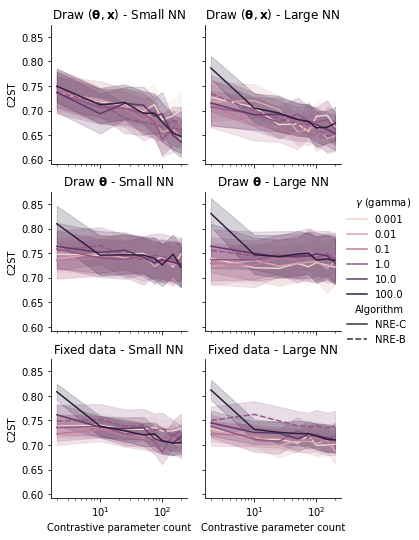

In [12]:
df_specific = df_preped[df_preped["task"] == "average"]
# prepare_df_for_plot(df_wide)[prepare_df_for_plot(df_wide)["task"] == "average"]
# df_specific["C2ST"] = df_specific["C2ST_Z"]
# df_specific["Contrastive parameter count"] = df_specific["num_contrastive_parameters"]
# df_specific["algorithm"] = df_specific["algorithm"].map(lambda x: "NRE-C" if x == "CNRE" else x)
# df_specific[r"Algorithm"] = df_specific.loc[:, "algorithm"]
# df_specific[r"$\gamma$ (gamma)"] = df_specific.loc[:, "gamma"]

fg = sns.relplot(
    data=df_specific,
    x="Contrastive parameter count",
    y="C2ST",
    hue="$\gamma$ (gamma)",
    style="Algorithm",
    style_order=["NRE-C", "NRE-B"],
    row="expr",
    col="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
    height=2.5,
    # legend=False,
)

# current_figsize = fg.figure.get_size_inches()
# aspect_ratio = current_figsize[0] / current_figsize[1]
# width = 5.5
# height = width / aspect_ratio
# fg.figure.set_size_inches(width, height)

# fg.figure.tight_layout()

for ax in fg.axes.flatten():
    ax.set(xscale='log')
    title = ax.get_title()
    
for ax in fg.axes[:, 0]:
    ax.set_ylabel("C2ST")
    
ddd = {
    "joint": "Draw " + r"$(\mathbf{\theta}, \mathbf{x})$",
    "prior": "Draw " + r"$\mathbf{\theta}$",
    "bench": "Fixed data",
}

fff = {
    2: "Small NN",
    3: "Large NN",
}
    
for key, ax in fg.axes_dict.items():
    ax.set_title(f"{ddd[key[0]]} - {fff[key[1]]}")

plt.savefig("rel-avg.pdf", dpi=300)

In [21]:
print(
    len(fg.legend.get_lines()),
    len(fg.legend.texts)
)

10 10
